In [1]:
!pip install torch==2.0.1+cu117 torchvision==0.15.2+cu117 torchaudio==2.0.2 --index-url https://download.pytorch.org/whl/cu117
import torch
from torch import nn
import os
from os import path
import torchvision
import torchvision.transforms as T
from typing import Sequence
from torchvision.transforms import functional as F
import numbers
import random
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import torchmetrics as TM
from tqdm import tqdm
from typing import List, Tuple

# Convert a pytorch tensor into a PIL image
t2img = T.ToPILImage()
# Convert a PIL image into a pytorch tensor
img2t = T.ToTensor()
working_dir = "data/"
models_dir = "models/"

# Validation: Check if CUDA is available
print(f"CUDA: {torch.cuda.is_available()}")

Looking in indexes: https://download.pytorch.org/whl/cu117
CUDA: True


In [2]:
!pip install torchmetrics

In [3]:
# Create a dataset wrapper that allows us to perform custom image augmentations
# on both the target and label (segmentation mask) images.
#
# These custom image augmentations are needed since we want to perform
# transforms such as:
# 1. Random horizontal flip
# 2. Image resize
#
# and these operations need to be applied consistently to both the input
# image as well as the segmentation mask.
class OxfordIIITPetsAugmented(torchvision.datasets.OxfordIIITPet):
    def __init__(
        self,
        root: str,
        split: str,
        target_types="segmentation",
        download=True,
        pre_transform=None,
        post_transform=None,
        pre_target_transform=None,
        post_target_transform=None,
        common_transform=None,
    ):
        super().__init__(
            root=root,
            split=split,
            target_types=target_types,
            download=download,
            transform=pre_transform,
            target_transform=pre_target_transform,
        )
        self.post_transform = post_transform
        self.post_target_transform = post_target_transform
        self.common_transform = common_transform

    def __len__(self):
        return super().__len__()

    def __getitem__(self, idx):
        (input, target) = super().__getitem__(idx)

        # Common transforms are performed on both the input and the labels
        # by creating a 4 channel image and running the transform on both.
        # Then the segmentation mask (4th channel) is separated out.
        if self.common_transform is not None:
            both = torch.cat([input, target], dim=0)
            both = self.common_transform(both)
            (input, target) = torch.split(both, 3, dim=0)
        # end if

        if self.post_transform is not None:
            input = self.post_transform(input)
        if self.post_target_transform is not None:
            target = self.post_target_transform(target)

        return (input, target)

In [4]:
# Simple torchvision compatible transform to send an input tensor
# to a pre-specified device.
class ToDevice(torch.nn.Module):
    """
    Sends the input object to the device specified in the
    object's constructor by calling .to(device) on the object.
    """
    def __init__(self, device):
        super().__init__()
        self.device = device

    def forward(self, img):
        return img.to(self.device)

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(device={device})"

In [5]:
def save_model_checkpoint(model: nn.Module, path: str) -> None:
    print(type(model))
    torch.save(model.state_dict(), path)


def get_device() -> torch.device:
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# Load model from saved checkpoint
def load_model_from_checkpoint(model: nn.Module, path: str):
    return model.load_state_dict(
        torch.load(
            path,
            map_location=get_device(),
        )
    )

# Send the Tensor or Model (input argument x) to the right device
# for this notebook. i.e. if GPU is enabled, then send to GPU/CUDA
# otherwise send to CPU.
def to_device(x):
    if torch.cuda.is_available():
        return x.cuda()
    else:
        return x.cpu()

def get_model_parameters(m):
    total_params = sum(
        param.numel() for param in m.parameters()
    )
    return total_params

def print_model_parameters(m):
    num_model_parameters = get_model_parameters(m)
    print(f"The Model has {num_model_parameters/1e6:.2f}M parameters")

def close_figures():
    while len(plt.get_fignums()) > 0:
        plt.close()

# Create a tensor for a segmentation trimap.
# Input: Float tensor with values in [0.0 .. 1.0]
# Output: Long tensor with values in {0, 1, 2}
def tensor_trimap(t):
    x = t * 255
    x = x.to(torch.long)
    x = x - 1
    return x

def args_to_dict(**kwargs):
    return kwargs

## 1. Wczytać dane OxfordPets

In [6]:
ds_train = OxfordIIITPetsAugmented("data/train", "trainval", target_types="segmentation", download=False)
ds_test = OxfordIIITPetsAugmented("data/test", "test", target_types="segmentation",download=False)

In [7]:
ds_test

Dataset OxfordIIITPetsAugmented
    Number of datapoints: 3669
    Root location: data/test

In [8]:
ds_train

Dataset OxfordIIITPetsAugmented
    Number of datapoints: 3680
    Root location: data/train

## 2. Podejrzeć jeden obrazek

In [9]:
!pip install opencv-python

In [10]:
import cv2

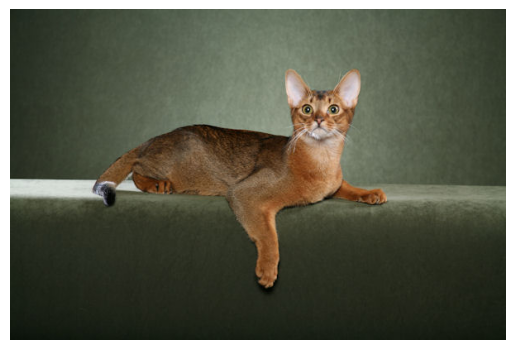

In [11]:
image = cv2.imread("data/train/oxford-iiit-pet/images/Abyssinian_1.jpg")

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


## 3. Przy pomocy funkcji pomocniczej wyświetlić target

In [12]:
from enum import IntEnum
class TrimapClasses(IntEnum):
    PET = 0
    BACKGROUND = 1
    BORDER = 2

# Convert a float trimap ({1, 2, 3} / 255.0) into a float tensor with
# pixel values in the range 0.0 to 1.0 so that the border pixels
# can be properly displayed.
def trimap2f(trimap):
    return (img2t(trimap) * 255.0 - 1) / 2

In [30]:
(ds_input, ds_target) = ds_train[0]

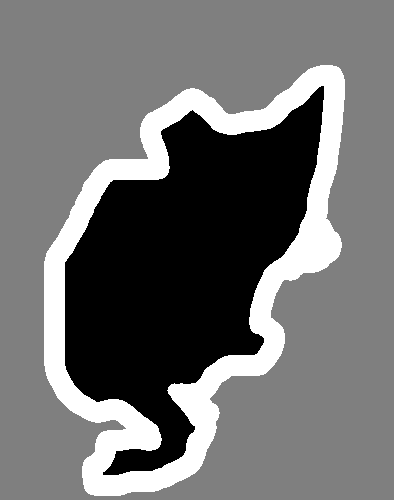

In [31]:
t2img(trimap2f(ds_target))

## 4. Przy pomocy podanych funkcji stworzyć DataLoadery, dodać transformacje obrazu w celu augmentacji

In [55]:
transform_dict = args_to_dict(
    pre_transform=T.ToTensor(),
    pre_target_transform=T.ToTensor(),
    
    common_transform=T.Compose([
        
        ToDevice(get_device()),
        T.Resize((128, 128), 
        interpolation=T.InterpolationMode.NEAREST),
        T.RandomHorizontalFlip(p=0.5),
    ]),
    
    post_transform=T.Compose([
        
        T.ColorJitter(contrast=0.3),
    ]),
    
    post_target_transform=T.Compose([
        
        T.Lambda(tensor_trimap),
    ]),
)

# Create the train and test instances of the data loader for the
# Oxford IIIT Pets dataset with random augmentations applied.
# The images are resized to 128x128 squares, so the aspect ratio
# will be chaged. We use the nearest neighbour resizing algorithm
# to avoid disturbing the pixel values in the provided segmentation
# mask.
pets_train = OxfordIIITPetsAugmented(
    root="data/train",
    split="trainval",
    download=False,
    **transform_dict,

)
pets_test = OxfordIIITPetsAugmented(
    root="data/test",
    split="test",
    download=False,
    **transform_dict,
)

pets_train, pets_val = torch.utils.data.random_split(pets_train, [3659, 21])

pets_train_loader = torch.utils.data.DataLoader(
    pets_train,
    batch_size=64,
    shuffle=True,
)
pets_test_loader = torch.utils.data.DataLoader(
    pets_test,
    batch_size=21,
    shuffle=True,
)
pets_val_loader = torch.utils.data.DataLoader(
    pets_val,
    batch_size=21,
    shuffle=True,
)

(train_pets_inputs, train_pets_targets) = next(iter(pets_train_loader))
(val_pets_inputs, val_pets_targets) = next(iter(pets_val_loader))
train_pets_inputs.shape, train_pets_targets.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 1, 128, 128]))

In [47]:
!pip install numba

     |████████████████████████████████| 3.7 MB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 43.6 MB 31.0 MB/s eta 0:00:01     |█████████████████████▏          | 28.9 MB 31.0 MB/s eta 0:00:01


In [45]:
!pip install GPUtil

Processing /home/ai/.cache/pip/wheels/ba/03/bb/7a97840eb54479b328672e15a536e49dc60da200fb21564d53/GPUtil-1.4.0-py3-none-any.whl


In [53]:
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(1)
    cuda.close()
    cuda.select_device(1)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()                           

Initial GPU Usage
| ID | GPU  | MEM  |
--------------------
|  0 | 100% |  70% |
|  1 |   0% | 100% |
GPU Usage after emptying the cache
| ID | GPU  | MEM  |
--------------------
|  0 | 100% |  71% |
|  1 |   0% | 100% |


In [54]:
import gc
gc.collect()
torch.cuda.empty_cache()

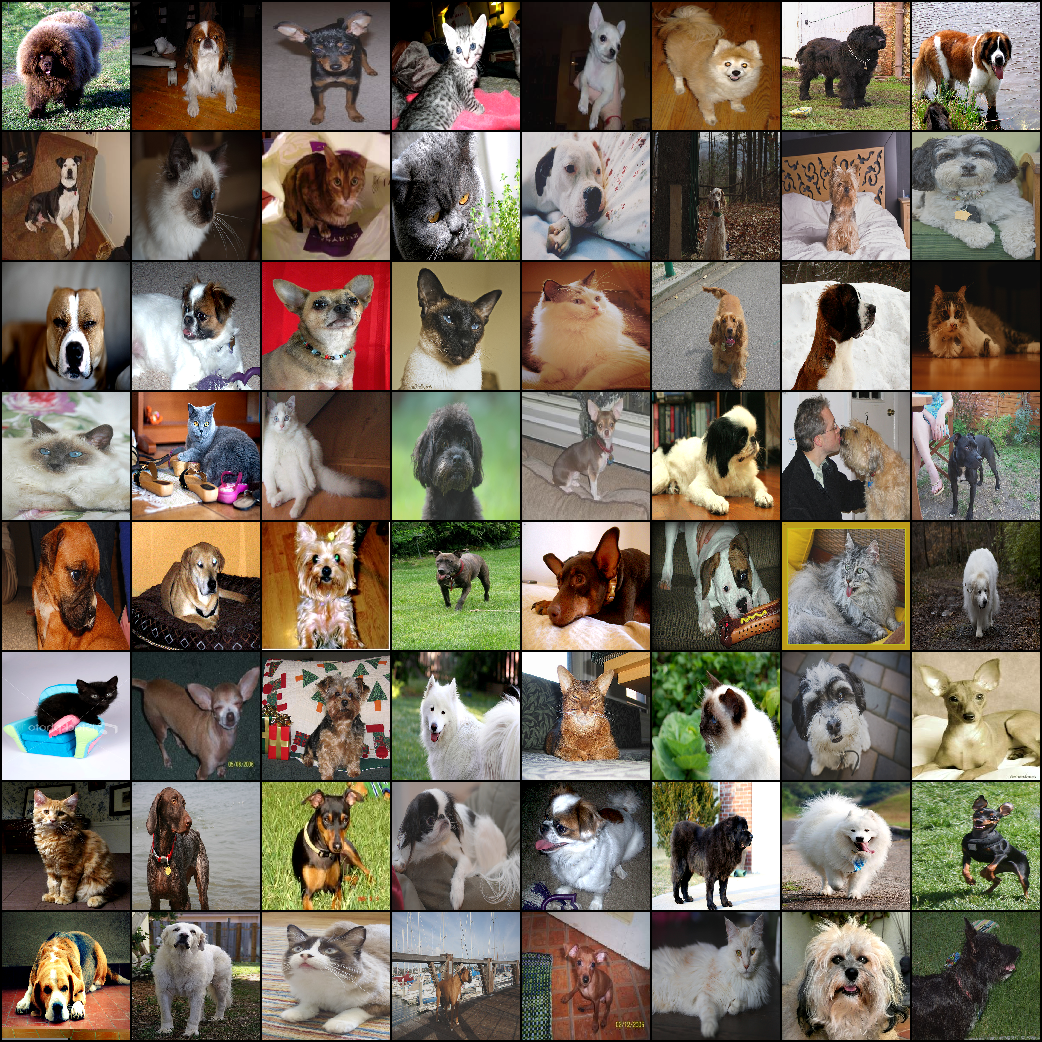

In [57]:
# Let's inspect some of the images.
pets_input_grid = torchvision.utils.make_grid(
    train_pets_inputs, nrow=8
)
t2img(
    pets_input_grid
)

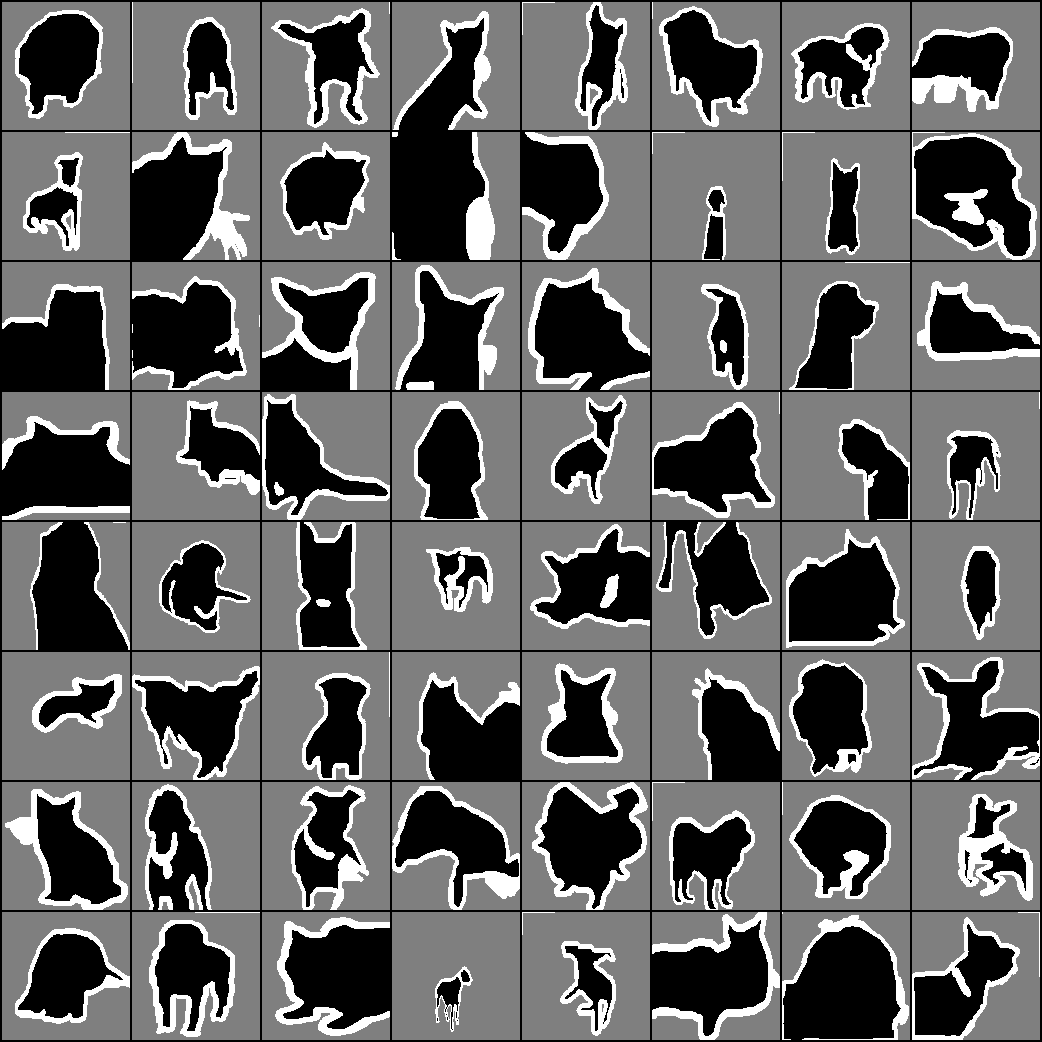

In [58]:
# Let's inspect the segmentation masks corresponding to the images above.
# When plotting the segmentation mask, we want to convert the tensor
# into a float tensor with values in the range [0.0 to 1.0]. However, the
# mask tensor has the values (0, 1, 2), so we divide by 2.0 to normalize.
pets_targets_grid = torchvision.utils.make_grid(
    train_pets_targets / 2.0, nrow=8
)
t2img(
    pets_targets_grid
)

In [59]:
#                  N  C  H
# The printed row is the W dimension.
train_pets_targets[3][0][4]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], device='cuda:1')

## 5. Zainicjalizuj i sprawdź czy model zwraca pożądany tensor

In [60]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )


    def forward(self, x):
        out = self.double_conv(x)
        return out


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)



class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.in_conv = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.out_conv = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.in_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        return self.out_conv(x)

In [61]:
# Define a custom IoU Metric for validating the model.
def IoUMetric(pred, gt, softmax=False):
    # Run softmax if input is logits.
    if softmax is True:
        pred = nn.Softmax(dim=1)(pred)

    # Add the one-hot encoded masks for all 3 output channels
    # (for all the classes) to a tensor named 'gt' (ground truth).
    gt = torch.cat([ (gt == i) for i in range(3) ], dim=1)
    # print(f"[2] Pred shape: {pred.shape}, gt shape: {gt.shape}")

    intersection = gt * pred
    union = gt + pred - intersection

    # Compute the sum over all the dimensions except for the batch dimension.
    iou = (intersection.sum(dim=(1, 2, 3)) + 0.001) / (union.sum(dim=(1, 2, 3)) + 0.001)

    # Compute the mean over the batch dimension.
    return iou.mean()

class IoULoss(nn.Module):
    def __init__(self, softmax=False):
        super().__init__()
        self.softmax = softmax

    # pred => Predictions (logits, B, 3, H, W)
    # gt => Ground Truth Labales (B, 1, H, W)
    def forward(self, pred, gt):
        # return 1.0 - IoUMetric(pred, gt, self.softmax)
        # Compute the negative log loss for stable training.
        return -(IoUMetric(pred, gt, self.softmax).log())

def test_custom_iou_loss():
    #               B, C, H, W
    x = torch.rand((2, 3, 2, 2), requires_grad=True)
    y = torch.randint(0, 3, (2, 1, 2, 2), dtype=torch.long)
    z = IoULoss(softmax=True)(x, y)
    return z

test_custom_iou_loss()

tensor(1.5819, grad_fn=<NegBackward0>)

In [62]:
def prediction_accuracy(ground_truth_labels, predicted_labels):
    eq = ground_truth_labels == predicted_labels
    return eq.sum().item() / predicted_labels.numel()

def print_val_dataset_masks(model, val_pets_inputs, val_pets_labels, epoch, save_path, show_plot):
    to_device(model.eval())
    predictions = model(to_device(val_pets_inputs))
    val_pets_labels = to_device(val_pets_labels)

    # print("Predictions Shape: {}".format(predictions.shape))
    pred = nn.Softmax(dim=1)(predictions)

    pred_labels = pred.argmax(dim=1)
    # Add a value 1 dimension at dim=1
    pred_labels = pred_labels.unsqueeze(1)
    # print("pred_labels.shape: {}".format(pred_labels.shape))
    pred_mask = pred_labels.to(torch.float)

    # accuracy = prediction_accuracy(val_pets_labels, pred_labels)
    iou = to_device(TM.classification.MulticlassJaccardIndex(3, average='micro', ignore_index=TrimapClasses.BACKGROUND))
    iou_accuracy = iou(pred_mask, val_pets_labels)
    pixel_metric = to_device(TM.classification.MulticlassAccuracy(3, average='micro'))
    pixel_accuracy = pixel_metric(pred_labels, val_pets_labels)
    custom_iou = IoUMetric(pred, val_pets_labels)
    title = f'Epoch: {epoch:02d}, Val Accuracy[Pixel: {pixel_accuracy:.4f}, IoU: {iou_accuracy:.4f}, Custom IoU: {custom_iou:.4f}]'
    print(title)
    # print(f"Accuracy: {accuracy:.4f}")

    # Close all previously open figures.
    close_figures()

    fig = plt.figure(figsize=(10, 12))
    fig.suptitle(title, fontsize=12)

    fig.add_subplot(3, 1, 1)
    plt.imshow(t2img(torchvision.utils.make_grid(val_pets_inputs, nrow=7)))
    plt.axis('off')
    plt.title("Targets")

    fig.add_subplot(3, 1, 2)
    plt.imshow(t2img(torchvision.utils.make_grid(val_pets_labels.float() / 2.0, nrow=7)))
    plt.axis('off')
    plt.title("Ground Truth Labels")

    fig.add_subplot(3, 1, 3)
    plt.imshow(t2img(torchvision.utils.make_grid(pred_mask / 2.0, nrow=7)))
    plt.axis('off')
    plt.title("Predicted Labels")

    if save_path is not None:
        plt.savefig(os.path.join(save_path, f"epoch_{epoch:02}.png"), format="png", bbox_inches="tight", pad_inches=0.4)

    if show_plot is False:
        close_figures()
    else:
        plt.show()

In [63]:
def test_loop(model, loader):
    to_device(model.eval())
    iou = to_device(TM.classification.MulticlassJaccardIndex(3, average='micro', ignore_index=TrimapClasses.BACKGROUND))
    pixel_metric = to_device(TM.classification.MulticlassAccuracy(3, average='micro'))

    iou_accuracies = []
    pixel_accuracies = []
    custom_iou_accuracies = []

    print_model_parameters(model)

    for batch_idx, (inputs, targets) in enumerate(loader, 0):
        inputs = to_device(inputs)
        targets = to_device(targets)
        predictions = model(inputs)

        pred_probabilities = nn.Softmax(dim=1)(predictions)
        pred_labels = predictions.argmax(dim=1)

        # Add a value 1 dimension at dim=1
        pred_labels = pred_labels.unsqueeze(1)
        # print("pred_labels.shape: {}".format(pred_labels.shape))
        pred_mask = pred_labels.to(torch.float)

        iou_accuracy = iou(pred_mask, targets)
        # pixel_accuracy = pixel_metric(pred_mask, targets)
        pixel_accuracy = pixel_metric(pred_labels, targets)
        custom_iou = IoUMetric(pred_probabilities, targets)
        iou_accuracies.append(iou_accuracy.item())
        pixel_accuracies.append(pixel_accuracy.item())
        custom_iou_accuracies.append(custom_iou.item())

        del inputs
        del targets
        del predictions

    iou_tensor = torch.FloatTensor(iou_accuracies)
    pixel_tensor = torch.FloatTensor(pixel_accuracies)
    custom_iou_tensor = torch.FloatTensor(custom_iou_accuracies)

    print("Test Dataset Accuracy")
    print(f"Pixel Accuracy: {pixel_tensor.mean():.4f}, IoU Accuracy: {iou_tensor.mean():.4f}, Custom IoU Accuracy: {custom_iou_tensor.mean():.4f}")

## 6. Przetestuj funkcję print_val_dataset_masks

In [67]:
m = UNet(n_channels=3 ,n_classes=3)
m.eval()
to_device(m)
m(to_device(train_pets_inputs)).shape

torch.Size([64, 3, 128, 128])

Epoch: 00, Val Accuracy[Pixel: 0.1196, IoU: 0.1958, Custom IoU: 0.1971]


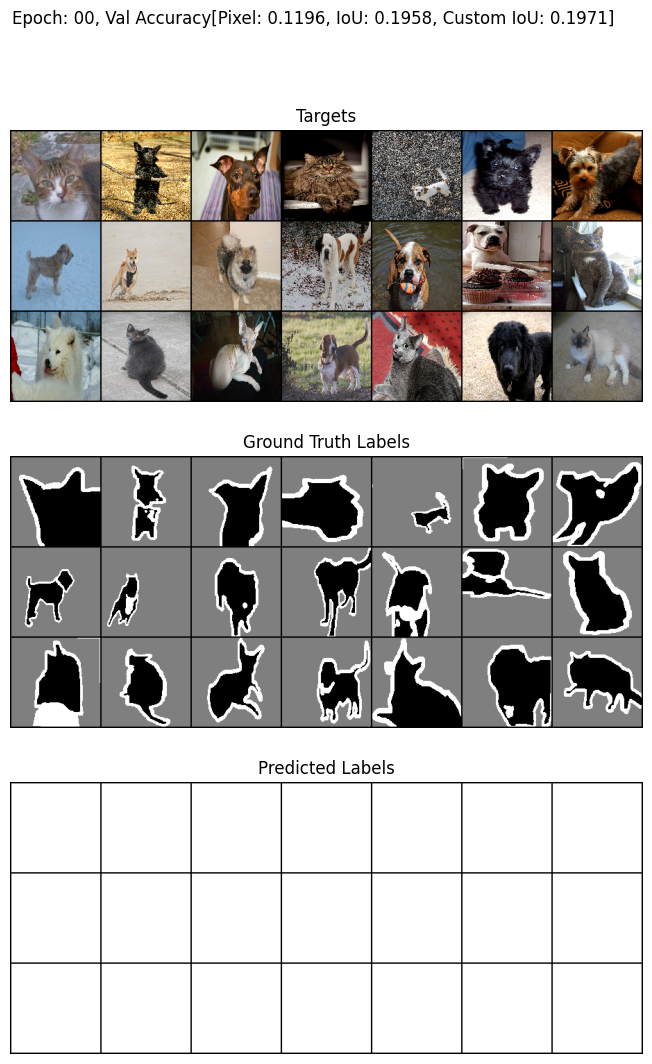

In [68]:
# Check if our helper functions work as expected and if the image is generated as expected.
save_path = os.path.join("data", "unet_basic_training_progress_images")
os.makedirs(save_path, exist_ok=True)
print_val_dataset_masks(
    m, val_pets_inputs, val_pets_targets, epoch=0, save_path=None, show_plot=True
)

In [69]:
# Optimizer and Learning Rate Scheduler.
to_device(m)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.7)

# Train the model for a single epoch
def train_model(model, train_data_loader, optimizer):
    to_device(model.train())
    cel = True
    if cel:
        criterion = nn.CrossEntropyLoss(reduction='mean')
    else:
        criterion = IoULoss(softmax=True)

    running_loss = 0.0
    running_samples = 0

    for batch_idx, (inputs, targets) in tqdm(enumerate(train_data_loader, 0)):
        optimizer.zero_grad()
        inputs = to_device(inputs)
        targets = to_device(targets)
        outputs = model(inputs)

        # The ground truth labels have a channel dimension (NCHW).
        # We need to remove it before passing it into
        # CrossEntropyLoss so that it has shape (NHW) and each element
        # is a value representing the class of the pixel.
        if cel:
            targets = targets.squeeze(dim=1)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_samples += targets.size(0)
        running_loss += loss.item()

    print("Trained {} samples, Train Loss: {:.4f}".format(
        running_samples,
        running_loss / (batch_idx+1),
    ))
    return running_loss / (batch_idx+1)


## 7. Na podastawie podanej pętli wytrenuj model

In [70]:
# Define training loop. This will train the model for multiple epochs.
#
# epochs: A tuple containing the start epoch (inclusive) and end epoch (exclusive).
#         The model is trained for [epoch[0] .. epoch[1]) epochs.
#
def train_loop(model, train_data_loader, val_data, epochs: Tuple[int, int], optimizer, scheduler, save_path: str, early_stopping_rounds: int = 3) -> None:
    val_inputs, val_targets = val_data
    epoch_i, epoch_j = epochs
    early_stopping_count = 0
    best_loss = np.inf
    for epoch in range(epoch_i, epoch_j):
        print(f"Epoch: {epoch:02d}, Learning Rate: {optimizer.param_groups[0]['lr']}")
        epoch_train_loss = train_model(model, train_data_loader, optimizer)
        if epoch_train_loss < best_loss:
            best_loss = epoch_train_loss
            early_stopping_count = 0
        else:
            early_stopping_count += 1
        with torch.inference_mode():
            # Display the plt in the final training epoch.
            print_val_dataset_masks(model, val_inputs, val_targets, epoch=epoch, save_path=save_path, show_plot=(epoch == epoch_j-1))

        if scheduler is not None:
            scheduler.step()
        print(f"Best train loss: {best_loss}")
        print(f"Current early stop count: {early_stopping_count}")
        print("")
        if early_stopping_count > early_stopping_rounds:
            print("Earlyyyy stopping! :D")

In [71]:
# Train our model for 20 epochs, and record the following:
#
# 1. Training Loss
# 2. Test accuracy metrics for a single batch (21 images) of test images. The following
#    metrics are computed:
#   2.1. Pixel Accuracy
#   2.2. IoU Accuracy (weighted)
#   2.3. Custom IoU Accuracy
#
# We also plot the following for each of the 21 images in the validation batch:
# 1. Input image
# 2. Ground truth segmentation mask
# 3. Predicted segmentation mask
#
# so that we can visually inspect the model's progres and determine how well the model
# is doing qualitatively. Note that the validation metrics on the set of 21 images in
# the validation set is displayed inline in the notebook only for the last training
# epoch.
#
save_path = os.path.join("data", "unet_basic_training_progress_images")
train_loop(
    m, pets_train_loader, (val_pets_inputs, val_pets_targets), (1, 21), optimizer, scheduler, save_path
)

Epoch: 01, Learning Rate: 0.001


58it [01:20,  1.38s/it]


Trained 3659 samples, Train Loss: 0.7079
Epoch: 01, Val Accuracy[Pixel: 0.7485, IoU: 0.5176, Custom IoU: 0.4807]
Best train loss: 0.7078696448227455
Current early stop count: 0

Epoch: 02, Learning Rate: 0.001


58it [01:14,  1.29s/it]


Trained 3659 samples, Train Loss: 0.5701
Epoch: 02, Val Accuracy[Pixel: 0.8225, IoU: 0.5730, Custom IoU: 0.5806]
Best train loss: 0.5701160764899748
Current early stop count: 0

Epoch: 03, Learning Rate: 0.001


58it [01:14,  1.29s/it]


Trained 3659 samples, Train Loss: 0.5086
Epoch: 03, Val Accuracy[Pixel: 0.7240, IoU: 0.5425, Custom IoU: 0.5159]
Best train loss: 0.5085993799669989
Current early stop count: 0

Epoch: 04, Learning Rate: 0.001


58it [01:15,  1.30s/it]


Trained 3659 samples, Train Loss: 0.4608
Epoch: 04, Val Accuracy[Pixel: 0.8347, IoU: 0.5938, Custom IoU: 0.6379]
Best train loss: 0.4607698357310788
Current early stop count: 0

Epoch: 05, Learning Rate: 0.001


58it [01:14,  1.29s/it]


Trained 3659 samples, Train Loss: 0.4165
Epoch: 05, Val Accuracy[Pixel: 0.8429, IoU: 0.6223, Custom IoU: 0.6509]
Best train loss: 0.41651586160577575
Current early stop count: 0

Epoch: 06, Learning Rate: 0.001


58it [01:14,  1.29s/it]


Trained 3659 samples, Train Loss: 0.3863
Epoch: 06, Val Accuracy[Pixel: 0.8131, IoU: 0.6521, Custom IoU: 0.6256]
Best train loss: 0.3862824609567379
Current early stop count: 0

Epoch: 07, Learning Rate: 0.001


58it [01:15,  1.30s/it]


Trained 3659 samples, Train Loss: 0.3594
Epoch: 07, Val Accuracy[Pixel: 0.8505, IoU: 0.5853, Custom IoU: 0.6762]
Best train loss: 0.3593861969380543
Current early stop count: 0

Epoch: 08, Learning Rate: 0.0007


58it [01:16,  1.31s/it]


Trained 3659 samples, Train Loss: 0.3303
Epoch: 08, Val Accuracy[Pixel: 0.8303, IoU: 0.6360, Custom IoU: 0.6298]
Best train loss: 0.3302996852274599
Current early stop count: 0

Epoch: 09, Learning Rate: 0.0007


58it [01:14,  1.28s/it]


Trained 3659 samples, Train Loss: 0.3195
Epoch: 09, Val Accuracy[Pixel: 0.8801, IoU: 0.6611, Custom IoU: 0.6954]
Best train loss: 0.31953155531965455
Current early stop count: 0

Epoch: 10, Learning Rate: 0.0007


58it [01:15,  1.30s/it]


Trained 3659 samples, Train Loss: 0.3078
Epoch: 10, Val Accuracy[Pixel: 0.8808, IoU: 0.6729, Custom IoU: 0.7069]
Best train loss: 0.3078385683996924
Current early stop count: 0

Epoch: 11, Learning Rate: 0.0007


58it [01:15,  1.29s/it]


Trained 3659 samples, Train Loss: 0.2942
Epoch: 11, Val Accuracy[Pixel: 0.8790, IoU: 0.6709, Custom IoU: 0.7240]
Best train loss: 0.29422204556136294
Current early stop count: 0

Epoch: 12, Learning Rate: 0.0007


58it [01:15,  1.30s/it]


Trained 3659 samples, Train Loss: 0.2835
Epoch: 12, Val Accuracy[Pixel: 0.8858, IoU: 0.6817, Custom IoU: 0.7187]
Best train loss: 0.28354451522744933
Current early stop count: 0

Epoch: 13, Learning Rate: 0.0007


1it [00:02,  2.53s/it]


KeyboardInterrupt: 

In [72]:
# Save the model's checkpoint.
save_model_checkpoint(
    m, f"OxfordPetsUnet.pth"
)

<class '__main__.UNet'>


In [73]:
# Load both model checkpoints.
load_model_from_checkpoint(
    m, f"OxfordPetsUnet.pth"
)

<All keys matched successfully>

## 8. Przetestuj działanie modelu

In [74]:
with torch.inference_mode():
    # Accuracy of the model.
    test_loop(
        m, pets_val_loader
    )
    

The Model has 31.04M parameters
Test Dataset Accuracy
Pixel Accuracy: 0.8697, IoU Accuracy: 0.6517, Custom IoU Accuracy: 0.7026


## 9. Stwórz gifa z postępami modelu

In [86]:
#zip -r unet_basic_training_progress_images.zip  unet_basic_training_progress_images
#convert -delay 20 -loop 0 *.png myimage.gif

In [90]:
!zip -r unet_basic_training_progress_images.zip unet_basic_training_progress_images
!convert -delay 20 -loop 0 *.png myimage.gif

  adding: unet_basic_training_progress_images/ (stored 0%)
  adding: unet_basic_training_progress_images/epoch_12.png (deflated 3%)
  adding: unet_basic_training_progress_images/epoch_07.png (deflated 3%)
  adding: unet_basic_training_progress_images/epoch_09.png (deflated 3%)
  adding: unet_basic_training_progress_images/epoch_11.png (deflated 3%)
  adding: unet_basic_training_progress_images/epoch_03.png (deflated 2%)
  adding: unet_basic_training_progress_images/epoch_01.png (deflated 3%)
  adding: unet_basic_training_progress_images/epoch_04.png (deflated 3%)
  adding: unet_basic_training_progress_images/epoch_02.png (deflated 3%)
  adding: unet_basic_training_progress_images/epoch_06.png (deflated 3%)
  adding: unet_basic_training_progress_images/epoch_05.png (deflated 3%)
  adding: unet_basic_training_progress_images/epoch_08.png (deflated 3%)
  adding: unet_basic_training_progress_images/epoch_10.png (deflated 3%)
/bin/bash: convert: command not found
